In [2]:
import numpy as np
import pandas as pd
import os, datetime
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
print('Tensorflow version: {}'.format(tf.__version__))
import math
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

2022-11-08 05:06:54.774740: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Tensorflow version: 2.5.0


In [2]:
batch_size = 64
seq_len = 128
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256

In [3]:
def restore_min_max_scalar(df, normalized_number):
    times = sorted(df.index.values)
    last_20pct = sorted(df.index.values)[-int(0.2*len(times))] # Last 20% of series
    min_return = min(df[(df.index < last_20pct)][['Open_ptc_change', 'High_ptc_change', 'Low_ptc_change', 'Close_ptc_change']].min(axis=0))
    max_return = max(df[(df.index < last_20pct)][['Open_ptc_change', 'High_ptc_change', 'Low_ptc_change', 'Close_ptc_change']].max(axis=0))
    original_number =  (normalized_number) * (max_return - min_return)  + min_return
    return original_number

In [4]:
def restore_close_price(total_df, input_df, pred_index, pred_number, moving_avg_step=15):
    previous_day_idx = pred_index-1
    # total_df: original df include train & test
    # next_day_index: 
    close_ptc_change =  restore_min_max_scalar(total_df, pred_number)
    previois_avg     = input_df.loc[pred_index-15:previous_day_idx,'Close'].mean()
    close_avg        = previois_avg * (close_ptc_change+1)
    restored_close   = (close_avg*moving_avg_step) - (input_df.loc[previous_day_idx- moving_avg_step+2:previous_day_idx, 'Close'].sum())
    return restored_close

In [4]:
#IBM_path = '/content/drive/MyDrive/Capital_Market/Medium_Tutorials/Medium-Part2/19620102_20200524_IBM.csv'

#df = pd.read_csv(IBM_path, delimiter=',', usecols=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
df = pd.read_csv('./BTC-USD_max.csv',sep=',')
del df['Adj Close']
# Replace 0 to avoid dividing by 0 later on
df['Volume'].replace(to_replace=0, method='ffill', inplace=True) 
df.sort_values('Date', inplace=True)
# max_index = df[df['Volume'] == df['Volume'].max()].index
# df.loc[max_index,'Volume'] = df['Volume'].max()/10
original_5yr_df = df.copy()

# Apply moving average with a window of 10 days to all columns
#df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(15).mean() 
#df = df.dropna(how='any', axis=0)

original_5yr_df[['Open_avg', 'High_avg', 'Low_avg', 'Close_avg', 'Volume_avg']] = original_5yr_df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean()
original_5yr_df = original_5yr_df.dropna(how='any', axis=0)
# Drop all rows with NaN values
#df = df.dropna(how='any', axis=0)
#original_5yr_df = original_5yr_df.dropna(how='any', axis=0)
#original_5yr_df.dropna(how='any', axis=0, inplace=True)
# original_5yr_df = df.copy()
original_5yr_df['Open_ptc_change']   = original_5yr_df['Open_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['High_ptc_change']   = original_5yr_df['High_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['Low_ptc_change']    = original_5yr_df['Low_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['Close_ptc_change']  = original_5yr_df['Close_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['Volume_ptc_change'] = original_5yr_df['Volume_avg'].pct_change()
original_5yr_df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values

###############################################################################
'''Create indexes to split dataset'''

times = sorted(original_5yr_df.index.values)
last_10pct = sorted(original_5yr_df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(original_5yr_df.index.values)[-int(0.2*len(times))] # Last 20% of series
print(len(times))
print(last_10pct)
print(last_20pct)
###############################################################################
'''Normalize price columns'''
min_return = min(original_5yr_df[(original_5yr_df.index < last_20pct)][['Open_ptc_change', 'High_ptc_change', 'Low_ptc_change', 'Close_ptc_change']].min(axis=0))
max_return = max(original_5yr_df[(original_5yr_df.index < last_20pct)][['Open_ptc_change', 'High_ptc_change', 'Low_ptc_change', 'Close_ptc_change']].max(axis=0))

original_5yr_df['Open_ptc_change_normalized']  = (original_5yr_df['Open_ptc_change'] - min_return) / (max_return - min_return)
original_5yr_df['High_ptc_change_normalized']  = (original_5yr_df['High_ptc_change'] - min_return) / (max_return - min_return)
original_5yr_df['Low_ptc_change_normalized']   = (original_5yr_df['Low_ptc_change'] - min_return) / (max_return - min_return)
original_5yr_df['Close_ptc_change_normalized'] = (original_5yr_df['Close_ptc_change'] - min_return) / (max_return - min_return)

###############################################################################
'''Normalize volume column'''
min_volume = min(original_5yr_df[(original_5yr_df.index < last_20pct)][['Volume_ptc_change']].min(axis=0))
max_volume = max(original_5yr_df[(original_5yr_df.index < last_20pct)][['Volume_ptc_change']].max(axis=0))

# Min-max normalize volume columns (0-1 range)
original_5yr_df['Volume_ptc_change_normalized'] = (original_5yr_df['Volume_ptc_change'] - min_volume) / (max_volume - min_volume)
#original_5yr_df = original_5yr_df.reset_index(drop=True)

df_train = original_5yr_df[(original_5yr_df.index < last_20pct)]  # Training data are 80% of total data
df_val = original_5yr_df[(original_5yr_df.index >= last_20pct) & (original_5yr_df.index < last_10pct)]
df_test = original_5yr_df[(original_5yr_df.index >= last_10pct)]

#Remove date column
df_train.drop(columns=['Date'], inplace=True)
df_val.drop(columns=['Date'], inplace=True)
df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train[['Open_ptc_change_normalized','High_ptc_change_normalized','Low_ptc_change_normalized','Close_ptc_change_normalized','Volume_ptc_change_normalized']].values
val_data = df_val[['Open_ptc_change_normalized','High_ptc_change_normalized','Low_ptc_change_normalized','Close_ptc_change_normalized','Volume_ptc_change_normalized']].values
test_data = df_test[['Open_ptc_change_normalized','High_ptc_change_normalized','Low_ptc_change_normalized','Close_ptc_change_normalized','Volume_ptc_change_normalized']].values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

2963
2677
2381
Training data shape: (2371, 5)
Validation data shape: (296, 5)
Test data shape: (296, 5)


In [6]:
times = sorted(original_5yr_df.index.values)
last_10pct = sorted(original_5yr_df.index.values)[-int(0.1*len(times))] # Last 10% of series
last_20pct = sorted(original_5yr_df.index.values)[-int(0.2*len(times))] # Last 20% of series

In [7]:
# original_5yr_df = df.copy()
original_5yr_df['Open_ptc_change']   = original_5yr_df['Open_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['High_ptc_change']   = original_5yr_df['High_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['Low_ptc_change']    = original_5yr_df['Low_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['Close_ptc_change']  = original_5yr_df['Close_avg'].pct_change() # Create arithmetic returns column
original_5yr_df['Volume_ptc_change'] = original_5yr_df['Volume_avg'].pct_change()
original_5yr_df.dropna(how='any', axis=0, inplace=True) # Drop all rows with NaN values
# min_max for 4 column
min_return = min(original_5yr_df[(original_5yr_df.index < last_20pct)][['Open_ptc_change', 'High_ptc_change', 'Low_ptc_change', 'Close_ptc_change']].min(axis=0))
max_return = max(original_5yr_df[(original_5yr_df.index < last_20pct)][['Open_ptc_change', 'High_ptc_change', 'Low_ptc_change', 'Close_ptc_change']].max(axis=0))

original_5yr_df['Open_ptc_change_normalized']  = (original_5yr_df['Open_ptc_change'] - min_return) / (max_return - min_return)
original_5yr_df['High_ptc_change_normalized']  = (original_5yr_df['High_ptc_change'] - min_return) / (max_return - min_return)
original_5yr_df['Low_ptc_change_normalized']   = (original_5yr_df['Low_ptc_change'] - min_return) / (max_return - min_return)
original_5yr_df['Close_ptc_change_normalized'] = (original_5yr_df['Close_ptc_change'] - min_return) / (max_return - min_return)

# min_max vol
min_volume = min(original_5yr_df[(original_5yr_df.index < last_20pct)][['Volume_ptc_change']].min(axis=0))
max_volume = max(original_5yr_df[(original_5yr_df.index < last_20pct)][['Volume_ptc_change']].max(axis=0))

# Min-max normalize volume columns (0-1 range)
original_5yr_df['Volume_ptc_change_normalized'] = (original_5yr_df['Volume_ptc_change'] - min_volume) / (max_volume - min_volume)
original_5yr_df = original_5yr_df.reset_index(drop=True)



In [8]:
df_train = original_5yr_df[(original_5yr_df.index < last_20pct)]  # Training data are 80% of total data
df_val = original_5yr_df[(original_5yr_df.index >= last_20pct) & (original_5yr_df.index < last_10pct)]
df_test = original_5yr_df[(original_5yr_df.index >= last_10pct)]

# Remove date column
# df_train.drop(columns=['Date'], inplace=True)
# df_val.drop(columns=['Date'], inplace=True)
# df_test.drop(columns=['Date'], inplace=True)

# Convert pandas columns into arrays
train_data = df_train[['Open_ptc_change_normalized','High_ptc_change_normalized','Low_ptc_change_normalized','Close_ptc_change_normalized','Volume_ptc_change_normalized']].values
val_data = df_val[['Open_ptc_change_normalized','High_ptc_change_normalized','Low_ptc_change_normalized','Close_ptc_change_normalized','Volume_ptc_change_normalized']].values
test_data = df_test[['Open_ptc_change_normalized','High_ptc_change_normalized','Low_ptc_change_normalized','Close_ptc_change_normalized','Volume_ptc_change_normalized']].values
print('Training data shape: {}'.format(train_data.shape))
print('Validation data shape: {}'.format(val_data.shape))
print('Test data shape: {}'.format(test_data.shape))

Training data shape: (2382, 5)
Validation data shape: (296, 5)
Test data shape: (280, 5)


In [9]:
# Training data
X_train, y_train = [], []
for i in range(seq_len, len(train_data)):
    X_train.append(train_data[i-seq_len:i]) # Chunks of training data with a length of 128 df-rows
    y_train.append(train_data[:, 3][i]) #Value of 4th column (Close Price) of df-row 128+1
X_train, y_train = np.array(X_train), np.array(y_train)

###############################################################################

# Validation data
X_val, y_val = [], []
for i in range(seq_len, len(val_data)):
    X_val.append(val_data[i-seq_len:i])
    y_val.append(val_data[:, 3][i])
X_val, y_val = np.array(X_val), np.array(y_val)

###############################################################################

# Test data
X_test, y_test = [], []
for i in range(seq_len, len(test_data)):
    X_test.append(test_data[i-seq_len:i])
    y_test.append(test_data[:, 3][i])    
X_test, y_test = np.array(X_test), np.array(y_test)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(2254, 128, 5) (2254,)
(168, 128, 5) (168,)
(152, 128, 5) (152,)


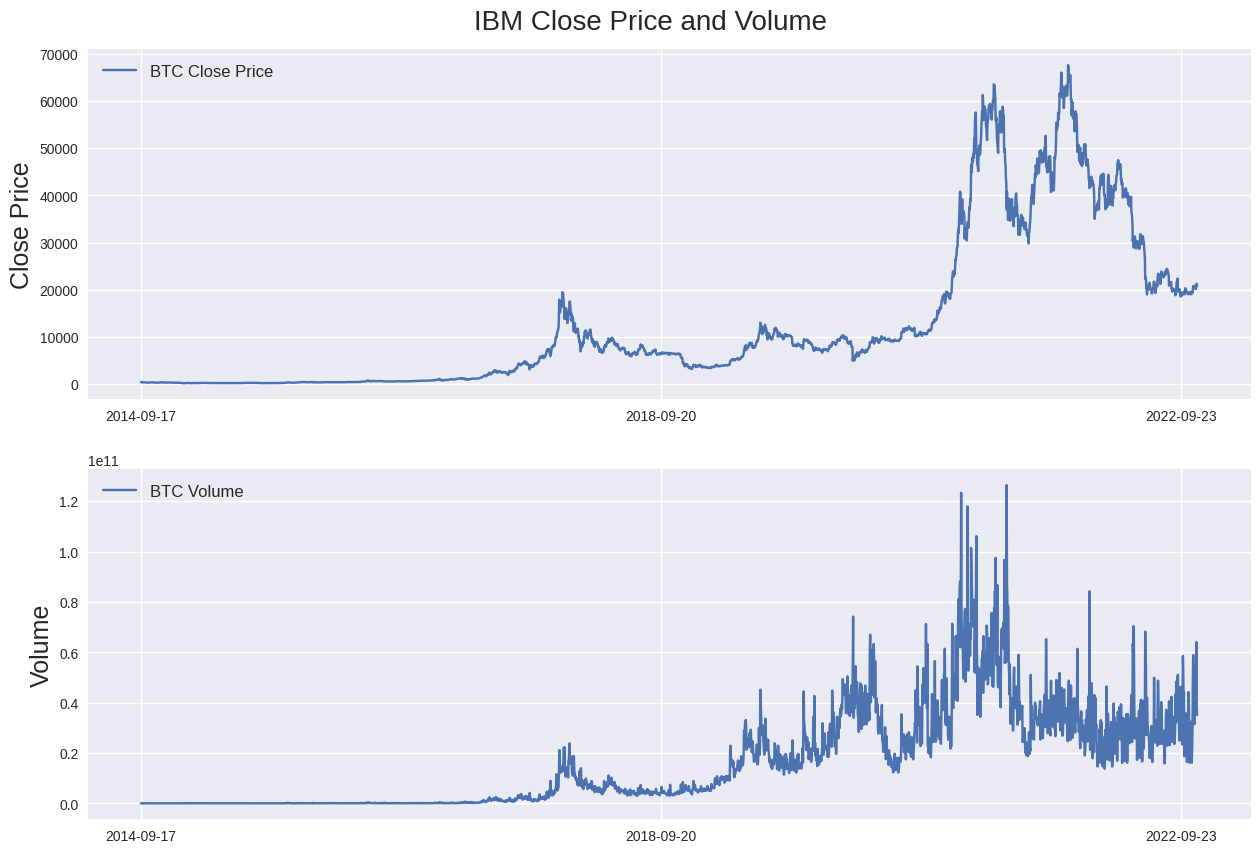

In [10]:
fig = plt.figure(figsize=(15,10))
st = fig.suptitle("IBM Close Price and Volume", fontsize=20)
st.set_y(0.92)

ax1 = fig.add_subplot(211)
ax1.plot(df['Close'], label='BTC Close Price')
ax1.set_xticks(range(0, df.shape[0], 1464))
ax1.set_xticklabels(df['Date'].loc[::1464])
ax1.set_ylabel('Close Price', fontsize=18)
ax1.legend(loc="upper left", fontsize=12)

ax2 = fig.add_subplot(212)
ax2.plot(df['Volume'], label='BTC Volume')
ax2.set_xticks(range(0, df.shape[0], 1464))
ax2.set_xticklabels(df['Date'].loc[::1464])
ax2.set_ylabel('Volume', fontsize=18)
ax2.legend(loc="upper left", fontsize=12)

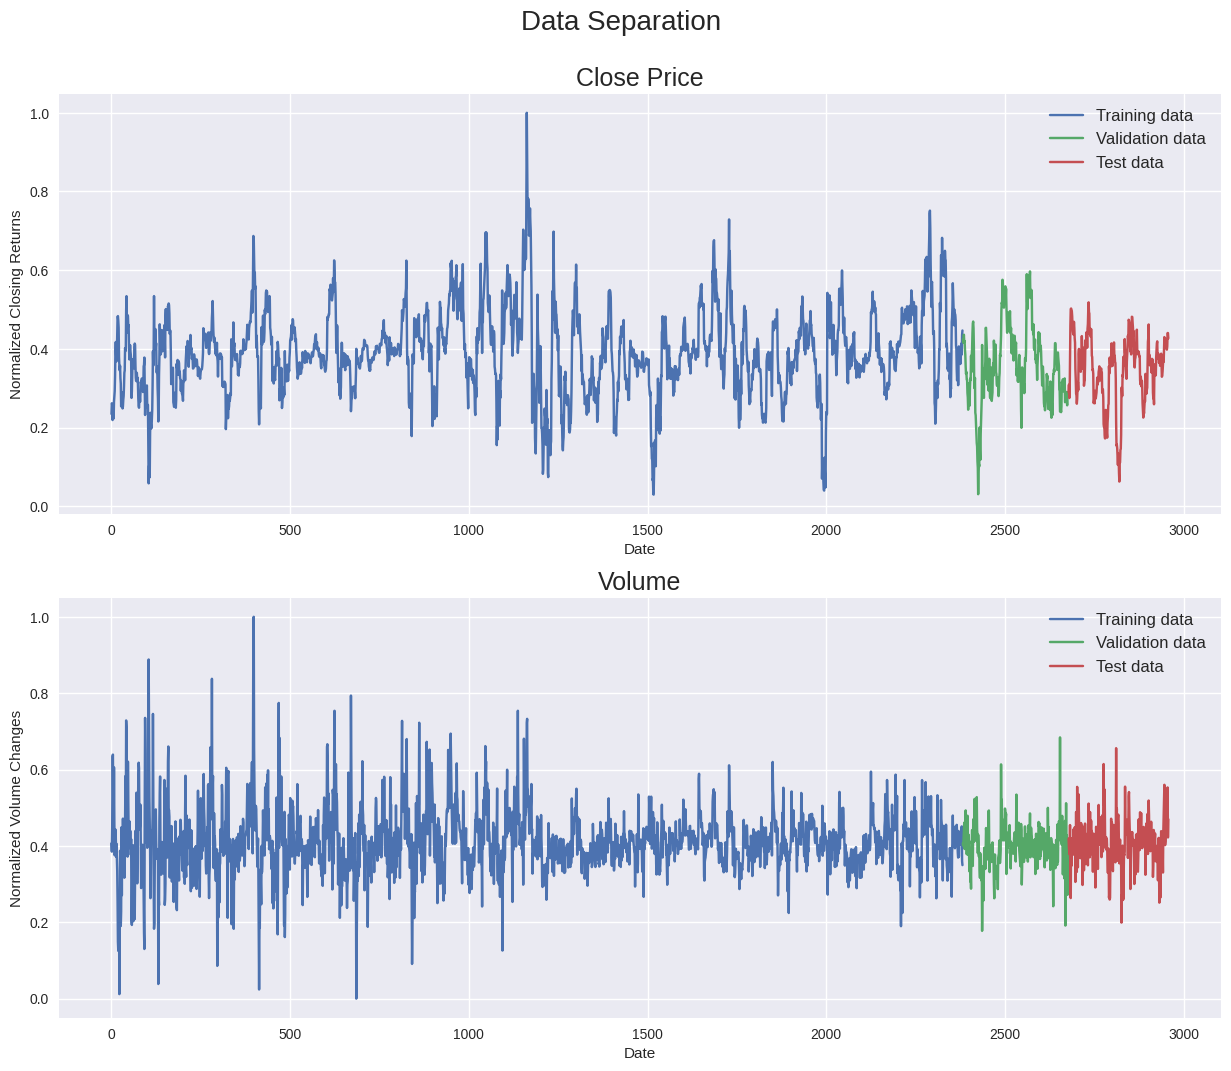

In [11]:
fig = plt.figure(figsize=(15,12))
st = fig.suptitle("Data Separation", fontsize=20)
st.set_y(0.95)

###############################################################################

ax1 = fig.add_subplot(211)
ax1.plot(np.arange(train_data.shape[0]), df_train['Close_ptc_change_normalized'], label='Training data')

ax1.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Close_ptc_change_normalized'], label='Validation data')

ax1.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Close_ptc_change_normalized'], label='Test data')
ax1.set_xlabel('Date')
ax1.set_ylabel('Normalized Closing Returns')
ax1.set_title("Close Price", fontsize=18)
ax1.legend(loc="best", fontsize=12)

###############################################################################

ax2 = fig.add_subplot(212)
ax2.plot(np.arange(train_data.shape[0]), df_train['Volume_ptc_change_normalized'], label='Training data')

ax2.plot(np.arange(train_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]), df_val['Volume_ptc_change_normalized'], label='Validation data')

ax2.plot(np.arange(train_data.shape[0]+val_data.shape[0], 
                   train_data.shape[0]+val_data.shape[0]+test_data.shape[0]), df_test['Volume_ptc_change_normalized'], label='Test data')
ax2.set_xlabel('Date')
ax2.set_ylabel('Normalized Volume Changes')
ax2.set_title("Volume", fontsize=18)
ax2.legend(loc="best", fontsize=12)

In [12]:
class Time2Vector(Layer):
  def __init__(self, seq_len, **kwargs):
    super(Time2Vector, self).__init__()
    self.seq_len = seq_len

  def build(self, input_shape):
    '''Initialize weights and biases with shape (batch, seq_len)'''
    self.weights_linear = self.add_weight(name='weight_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.bias_linear = self.add_weight(name='bias_linear',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)
    
    self.weights_periodic = self.add_weight(name='weight_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

    self.bias_periodic = self.add_weight(name='bias_periodic',
                                shape=(int(self.seq_len),),
                                initializer='uniform',
                                trainable=True)

  def call(self, x):
    '''Calculate linear and periodic time features'''
    x = tf.math.reduce_mean(x[:,:,:4], axis=-1) 
    time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
    time_linear = tf.expand_dims(time_linear, axis=-1) # Add dimension (batch, seq_len, 1)
    
    time_periodic = tf.math.sin(tf.multiply(x, self.weights_periodic) + self.bias_periodic)
    time_periodic = tf.expand_dims(time_periodic, axis=-1) # Add dimension (batch, seq_len, 1)
    return tf.concat([time_linear, time_periodic], axis=-1) # shape = (batch, seq_len, 2)
   
  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'seq_len': self.seq_len})
    return config
  

In [13]:
class SingleAttention(Layer):
  def __init__(self, d_k, d_v):
    super(SingleAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v

  def build(self, input_shape):
    self.query = Dense(self.d_k, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')
    
    self.key = Dense(self.d_k, 
                     input_shape=input_shape, 
                     kernel_initializer='glorot_uniform', 
                     bias_initializer='glorot_uniform')
    
    self.value = Dense(self.d_v, 
                       input_shape=input_shape, 
                       kernel_initializer='glorot_uniform', 
                       bias_initializer='glorot_uniform')

  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    q = self.query(inputs[0])
    k = self.key(inputs[1])

    attn_weights = tf.matmul(q, k, transpose_b=True)
    attn_weights = tf.map_fn(lambda x: x/np.sqrt(self.d_k), attn_weights)
    attn_weights = tf.nn.softmax(attn_weights, axis=-1)
    
    v = self.value(inputs[2])
    attn_out = tf.matmul(attn_weights, v)
    return attn_out    

#############################################################################

class MultiAttention(Layer):
  def __init__(self, d_k, d_v, n_heads):
    super(MultiAttention, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.attn_heads = list()

  def build(self, input_shape):
    for n in range(self.n_heads):
      self.attn_heads.append(SingleAttention(self.d_k, self.d_v))  
    
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1]=7 
    self.linear = Dense(input_shape[0][-1], 
                        input_shape=input_shape, 
                        kernel_initializer='glorot_uniform', 
                        bias_initializer='glorot_uniform')

  def call(self, inputs):
    attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
    concat_attn = tf.concat(attn, axis=-1)
    multi_linear = self.linear(concat_attn)
    return multi_linear   

#############################################################################

class TransformerEncoder(Layer):
  def __init__(self, d_k, d_v, n_heads, ff_dim, dropout=0.1, **kwargs):
    super(TransformerEncoder, self).__init__()
    self.d_k = d_k
    self.d_v = d_v
    self.n_heads = n_heads
    self.ff_dim = ff_dim
    self.attn_heads = list()
    self.dropout_rate = dropout

  def build(self, input_shape):
    self.attn_multi = MultiAttention(self.d_k, self.d_v, self.n_heads)
    self.attn_dropout = Dropout(self.dropout_rate)
    self.attn_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)

    self.ff_conv1D_1 = Conv1D(filters=self.ff_dim, kernel_size=1, activation='relu')
    # input_shape[0]=(batch, seq_len, 7), input_shape[0][-1] = 7 
    self.ff_conv1D_2 = Conv1D(filters=input_shape[0][-1], kernel_size=1) 
    self.ff_dropout = Dropout(self.dropout_rate)
    self.ff_normalize = LayerNormalization(input_shape=input_shape, epsilon=1e-6)    
  
  def call(self, inputs): # inputs = (in_seq, in_seq, in_seq)
    attn_layer = self.attn_multi(inputs)
    attn_layer = self.attn_dropout(attn_layer)
    attn_layer = self.attn_normalize(inputs[0] + attn_layer)

    ff_layer = self.ff_conv1D_1(attn_layer)
    ff_layer = self.ff_conv1D_2(ff_layer)
    ff_layer = self.ff_dropout(ff_layer)
    ff_layer = self.ff_normalize(inputs[0] + ff_layer)
    return ff_layer 

  def get_config(self): # Needed for saving and loading model with custom layer
    config = super().get_config().copy()
    config.update({'d_k': self.d_k,
                   'd_v': self.d_v,
                   'n_heads': self.n_heads,
                   'ff_dim': self.ff_dim,
                   'attn_heads': self.attn_heads,
                   'dropout_rate': self.dropout_rate})
    return config          

In [14]:
def get_optimizer():
    LR = 5e-2
    #LR_DECAY = 0.3
    #return tfa.optimizers.RectifiedAdam(learning_rate=LR,weight_decay=LR_DECAY)
    return tfa.optimizers.RectifiedAdam(learning_rate=LR)

def create_model():
    #'''Initialize time and transformer layers'''
    time_embedding = Time2Vector(seq_len)
    attn_layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)
    attn_layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim)

    #'''Construct model'''
    in_seq = Input(shape=(seq_len, 5))
    x = time_embedding(in_seq)
    x = Concatenate(axis=-1)([in_seq, x])
    x = attn_layer1((x, x, x))
    x = attn_layer2((x, x, x))
    x = attn_layer3((x, x, x))
    x = GlobalAveragePooling1D(data_format='channels_first')(x)
    x = Dropout(0.1)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.1)(x)
    out = Dense(1, activation='linear')(x)

    model = Model(inputs=in_seq, outputs=out)
    model.compile(loss='mse', optimizer=get_optimizer(), metrics=['mae', 'mape'])
    return model

def scheduler(epoch, lr):
    initial_lrate = 1e-2
    upper_lrate = 5e-2
    lower_lrate = 1e-5
    limited_epoch = 3
    drop = 0.85
    epochs_drop = 3.0
    if epoch <= limited_epoch:
        lrate = initial_lrate + (epoch * (upper_lrate-initial_lrate)/limited_epoch)
    else:
        lrate = lr * math.pow(drop,  (1+epoch)/epochs_drop)
        if lrate <= lower_lrate:
            lrate = lower_lrate
    print("learning rate = "+str(lrate))
    return lrate

In [15]:
model = create_model()
model.summary()
# call back
#lr_callback    = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)
reduce_lr  = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=5, min_lr=0.00005,verbose=1)

check_point_callback = tf.keras.callbacks.ModelCheckpoint('Transformer+TimeEmbedding.hdf5', 
                                              monitor='val_loss', 
                                              save_best_only=True, verbose=1)


early_stop_callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0,
                patience=30,
                verbose=1,
                mode="min",
                baseline=None,
                restore_best_weights=False)
# callback = tf.keras.callbacks.ModelCheckpoint('preprocess_restore.hdf5', 
#                                               monitor='val_loss', 
#                                               save_best_only=True, 
#                                               verbose=1)

history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=100, 
                    callbacks=[reduce_lr, early_stop_callback],
                    validation_data=(X_val, y_val))  
model.save("preprocess_version.hdf5")

2022-11-08 02:12:45.292953: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-11-08 02:12:45.334817: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2022-11-08 02:12:45.334892: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-11-08 02:12:45.340319: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-11-08 02:12:45.340430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-11-08 02:12:45.342132: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuff

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 5)]     0                                            
__________________________________________________________________________________________________
time2_vector (Time2Vector)      (None, 128, 2)       512         input_1[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 128, 7)       0           input_1[0][0]                    
                                                                 time2_vector[0][0]               
__________________________________________________________________________________________________
transformer_encoder (Transforme (None, 128, 7)       99114       concatenate[0][0]            

2022-11-08 02:12:50.101280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-11-08 02:12:50.102068: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 1800000000 Hz
2022-11-08 02:13:52.949201: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-11-08 02:13:53.712141: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-11-08 02:13:53.963136: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2022-11-08 02:13:54.711440: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8200


36/36 [==============================] - 118s 1s/step - loss: 0.0220 - mae: 0.1073 - mape: 32.5652 - val_loss: 0.0128 - val_mae: 0.0981 - val_mape: 31.3767
Epoch 2/100
36/36 [==============================] - 47s 1s/step - loss: 0.0121 - mae: 0.0818 - mape: 26.9712 - val_loss: 0.0083 - val_mae: 0.0748 - val_mape: 22.8669
Epoch 3/100
36/36 [==============================] - 47s 1s/step - loss: 0.0113 - mae: 0.0786 - mape: 26.2521 - val_loss: 0.0084 - val_mae: 0.0756 - val_mape: 23.2244
Epoch 4/100
36/36 [==============================] - 47s 1s/step - loss: 0.0113 - mae: 0.0786 - mape: 26.1034 - val_loss: 0.0076 - val_mae: 0.0700 - val_mape: 20.7209
Epoch 5/100
36/36 [==============================] - 47s 1s/step - loss: 0.0127 - mae: 0.0850 - mape: 27.6712 - val_loss: 0.0099 - val_mae: 0.0842 - val_mape: 26.4774
Epoch 6/100
36/36 [==============================] - 48s 1s/step - loss: 0.0115 - mae: 0.0795 - mape: 26.3818 - val_loss: 0.0076 - val_mae: 0.0700 - val_mape: 20.7044
Epoch 7/1

 
Evaluation metrics
Training Data - Loss: 0.0110, MAE: 0.0770, MAPE: 25.7434
Validation Data - Loss: 0.0084, MAE: 0.0757, MAPE: 23.2647
Test Data - Loss: 0.0102, MAE: 0.0678, MAPE: 34.7783


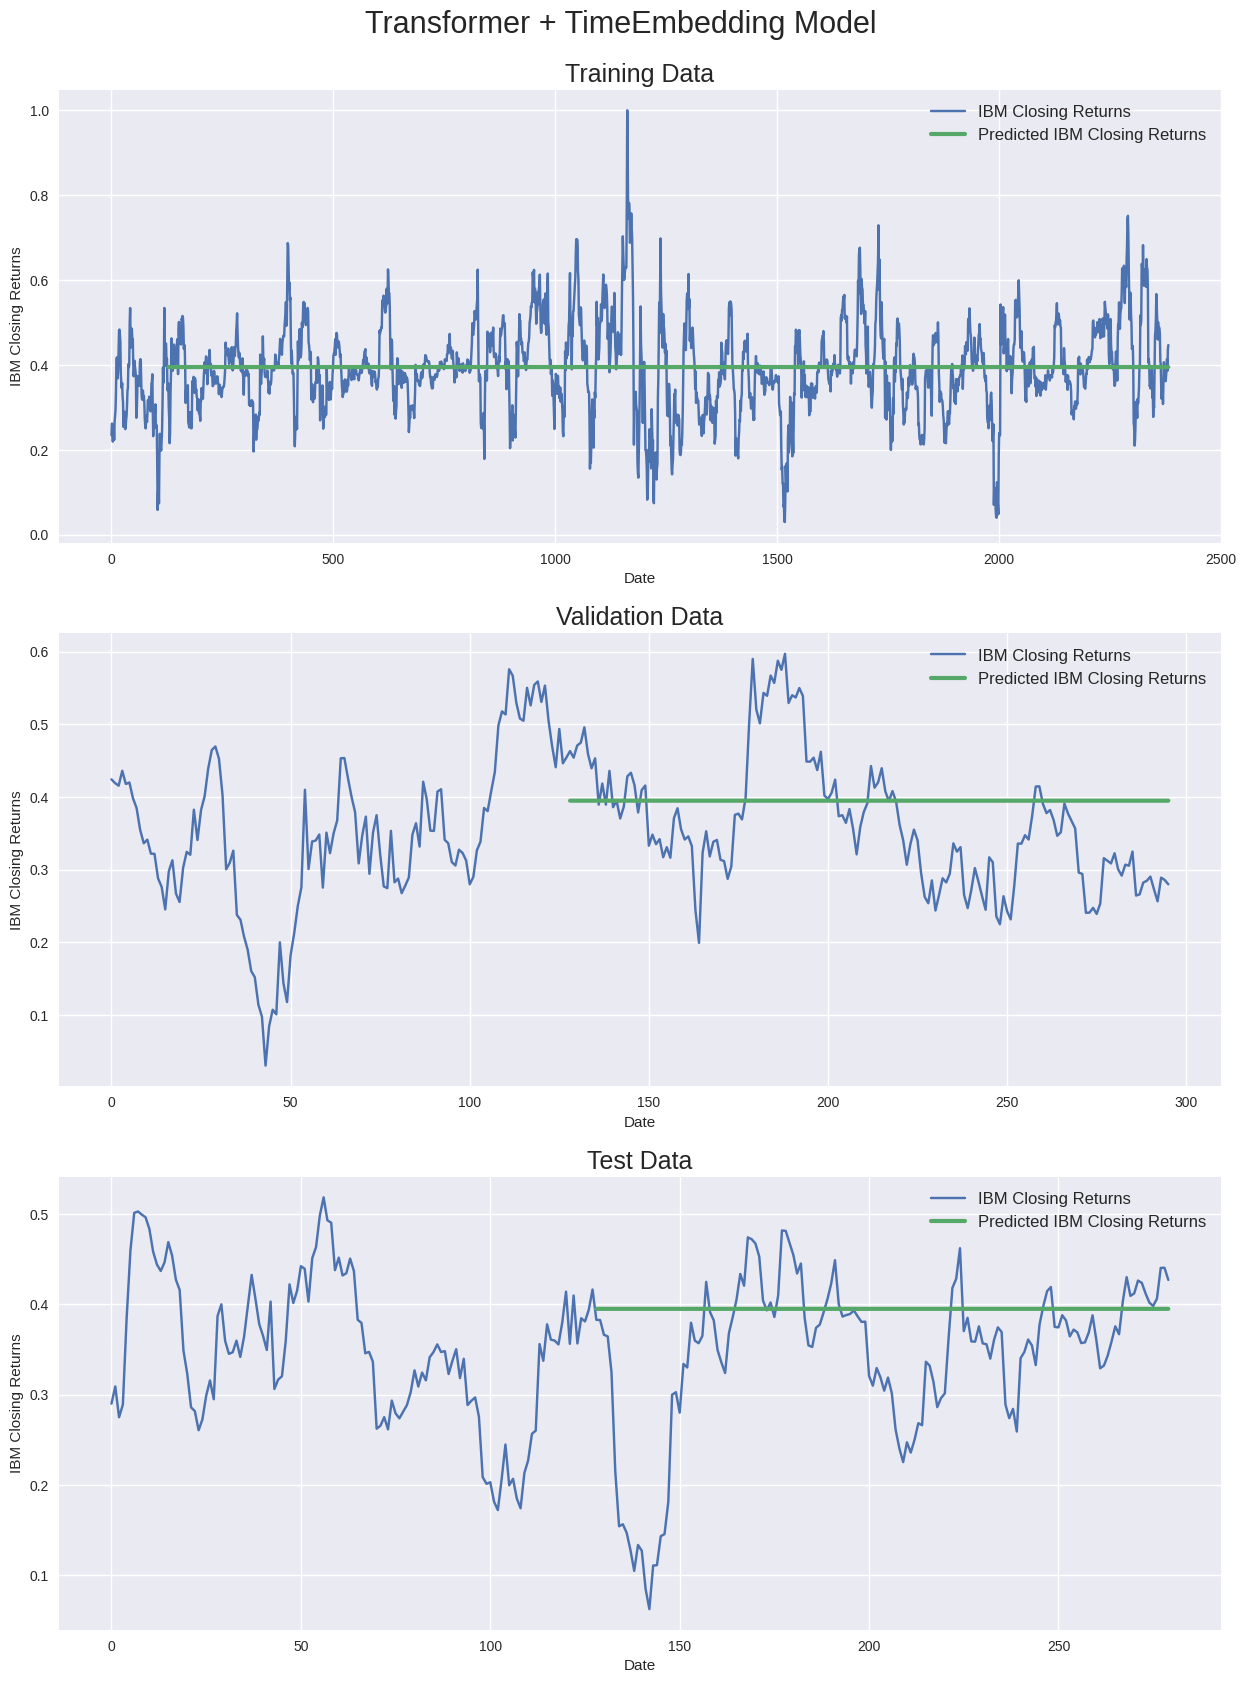

In [25]:
model = tf.keras.models.load_model('./preprocess_version.hdf5',
                                   custom_objects={'Time2Vector': Time2Vector, 
                                                   'SingleAttention': SingleAttention,
                                                   'MultiAttention': MultiAttention,
                                                   'TransformerEncoder': TransformerEncoder})

###############################################################################
'''Calculate predictions and metrics'''

#Calculate predication for training, validation and test data
train_pred = model.predict(X_train)
val_pred = model.predict(X_val)
test_pred = model.predict(X_test)

#Print evaluation metrics for all datasets
train_eval = model.evaluate(X_train, y_train, verbose=0)
val_eval = model.evaluate(X_val, y_val, verbose=0)
test_eval = model.evaluate(X_test, y_test, verbose=0)
print(' ')
print('Evaluation metrics')
print('Training Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(train_eval[0], train_eval[1], train_eval[2]))
print('Validation Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(val_eval[0], val_eval[1], val_eval[2]))
print('Test Data - Loss: {:.4f}, MAE: {:.4f}, MAPE: {:.4f}'.format(test_eval[0], test_eval[1], test_eval[2]))

###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(val_data[:, 3], label='IBM Closing Returns')
ax21.plot(np.arange(seq_len, val_pred.shape[0]+seq_len), val_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('IBM Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(test_data[:, 3], label='IBM Closing Returns')
ax31.plot(np.arange(seq_len, test_pred.shape[0]+seq_len), test_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('IBM Closing Returns')
ax31.legend(loc="best", fontsize=12)

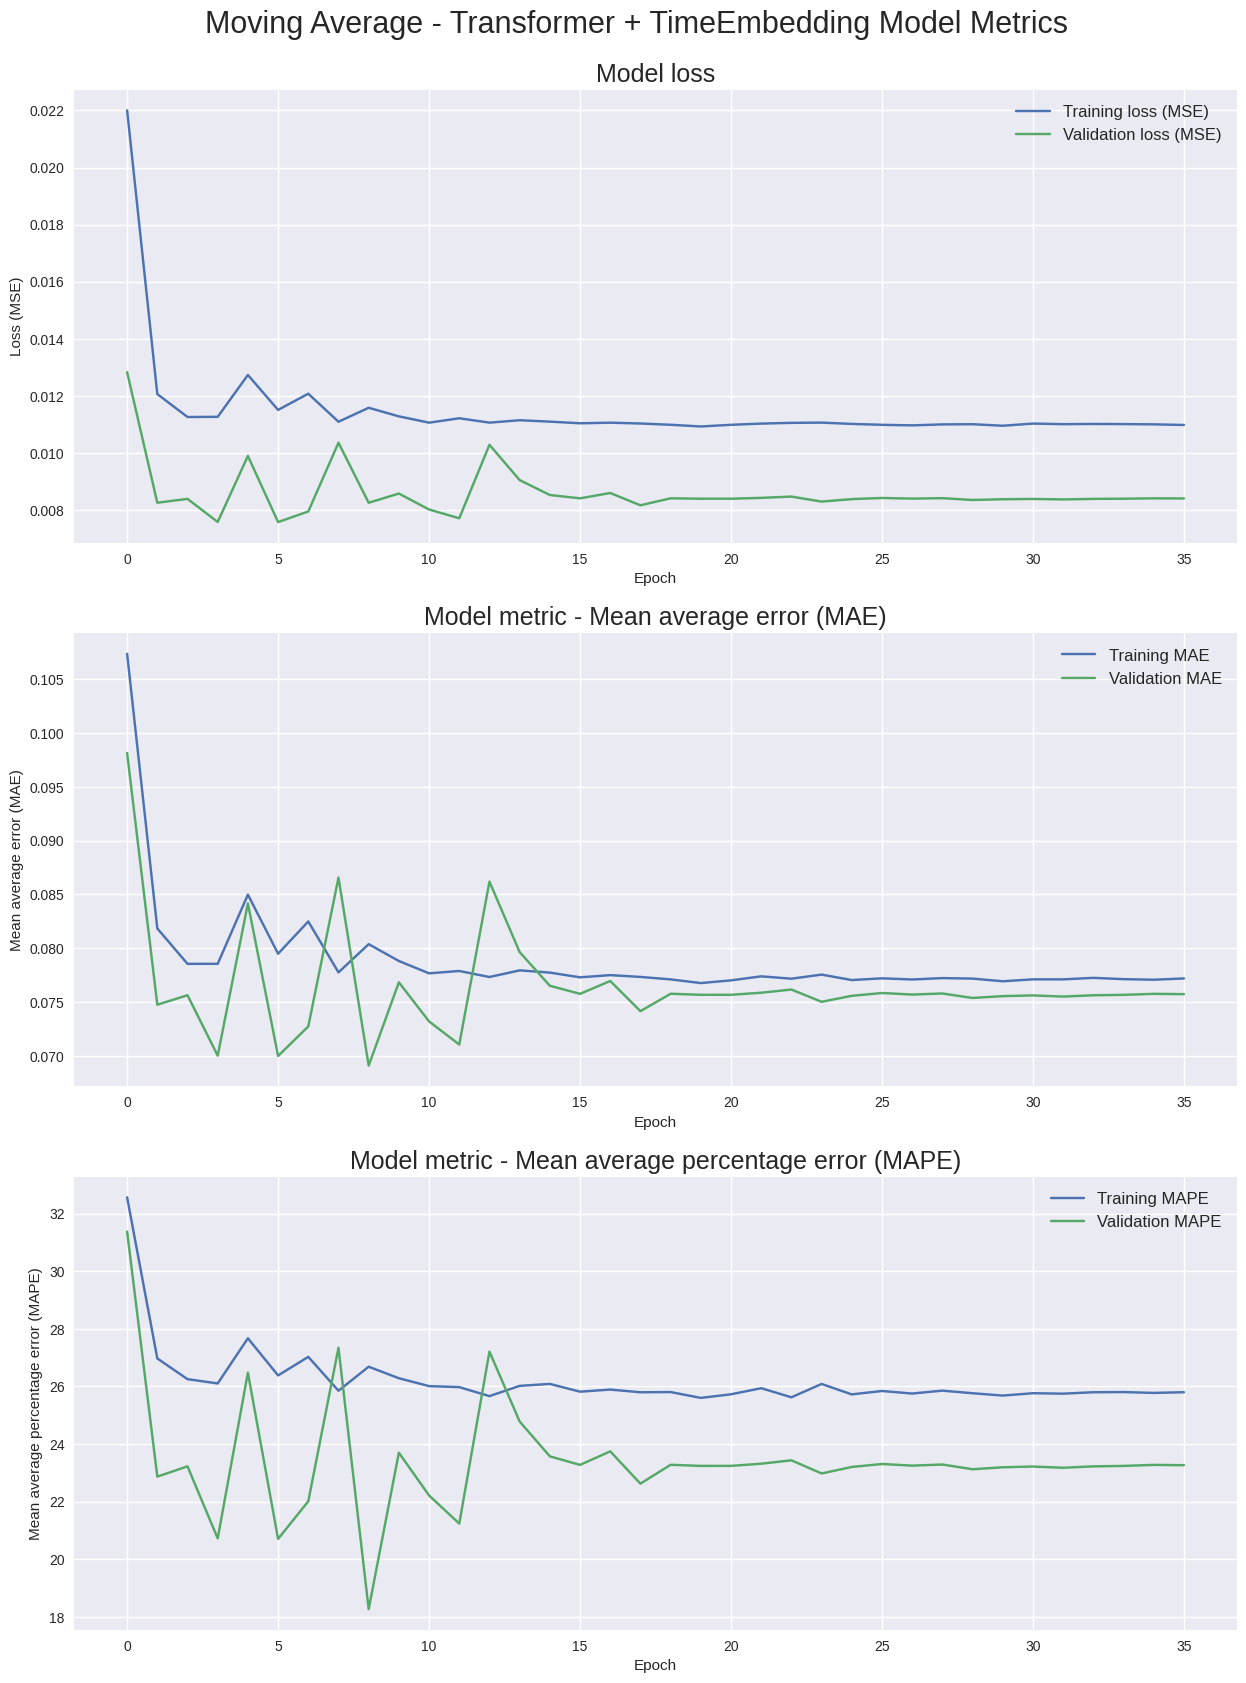

In [26]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)

In [18]:
# def restore_close_price(total_df, input_df, pred_index, pred_number, moving_avg_step=15):
#     previous_day_idx = pred_index-1
#     # total_df: original df include train & test
#     # next_day_index: 
#     close_ptc_change =  restore_min_max_scalar(total_df, pred_number)

#     print('close_ptc_change',close_ptc_change)
#     previois_avg     = input_df.loc[pred_index-15:previous_day_idx,'Close'].mean()
#     #previois_avg     = total_df.loc[previous_day_idx,'Close_avg']
    
#     close_avg        = previois_avg * (close_ptc_change+1)
#     print(close_avg)
#     restored_close   = (close_avg*moving_avg_step) - (input_df.loc[previous_day_idx- moving_avg_step+2:previous_day_idx, 'Close'].sum())
#     return restored_close

In [19]:
pred_df_train = df_train.reset_index(drop=True)
pred_df_train.loc[128:,'pred_close_ptc_change_normalized'] = train_pred


pred_df_val   = df_val.reset_index(drop=True)
pred_df_val.loc[128:,'pred_close_ptc_change_normalized'] = val_pred

pred_df_test  = df_test.reset_index(drop=True)
pred_df_test.loc[128:,'pred_close_ptc_change_normalized'] = test_pred

# save original close
pred_df_train['original_close']  = pred_df_train['Close']
pred_df_val['original_close']    = pred_df_val['Close']
pred_df_test['original_close']   = pred_df_test['Close']

for i in range(129, len(pred_df_train)):
    pred_number = pred_df_train['pred_close_ptc_change_normalized'][i]
    pred_close  = restore_close_price(original_5yr_df, pred_df_train, i, pred_number, 15)
    pred_df_train.loc[i,'Close'] = pred_close

for i in range(129, len(pred_df_val)):
    pred_number = pred_df_val['pred_close_ptc_change_normalized'][i]
    pred_close  = restore_close_price(original_5yr_df, pred_df_val, i, pred_number, 15)
    pred_df_val.loc[i,'Close'] = pred_close
    
for i in range(129, len(pred_df_test)):
    pred_number = pred_df_test['pred_close_ptc_change_normalized'][i]
    pred_close  = restore_close_price(original_5yr_df, pred_df_test, i, pred_number, 15)
    pred_df_test.loc[i,'Close'] = pred_close

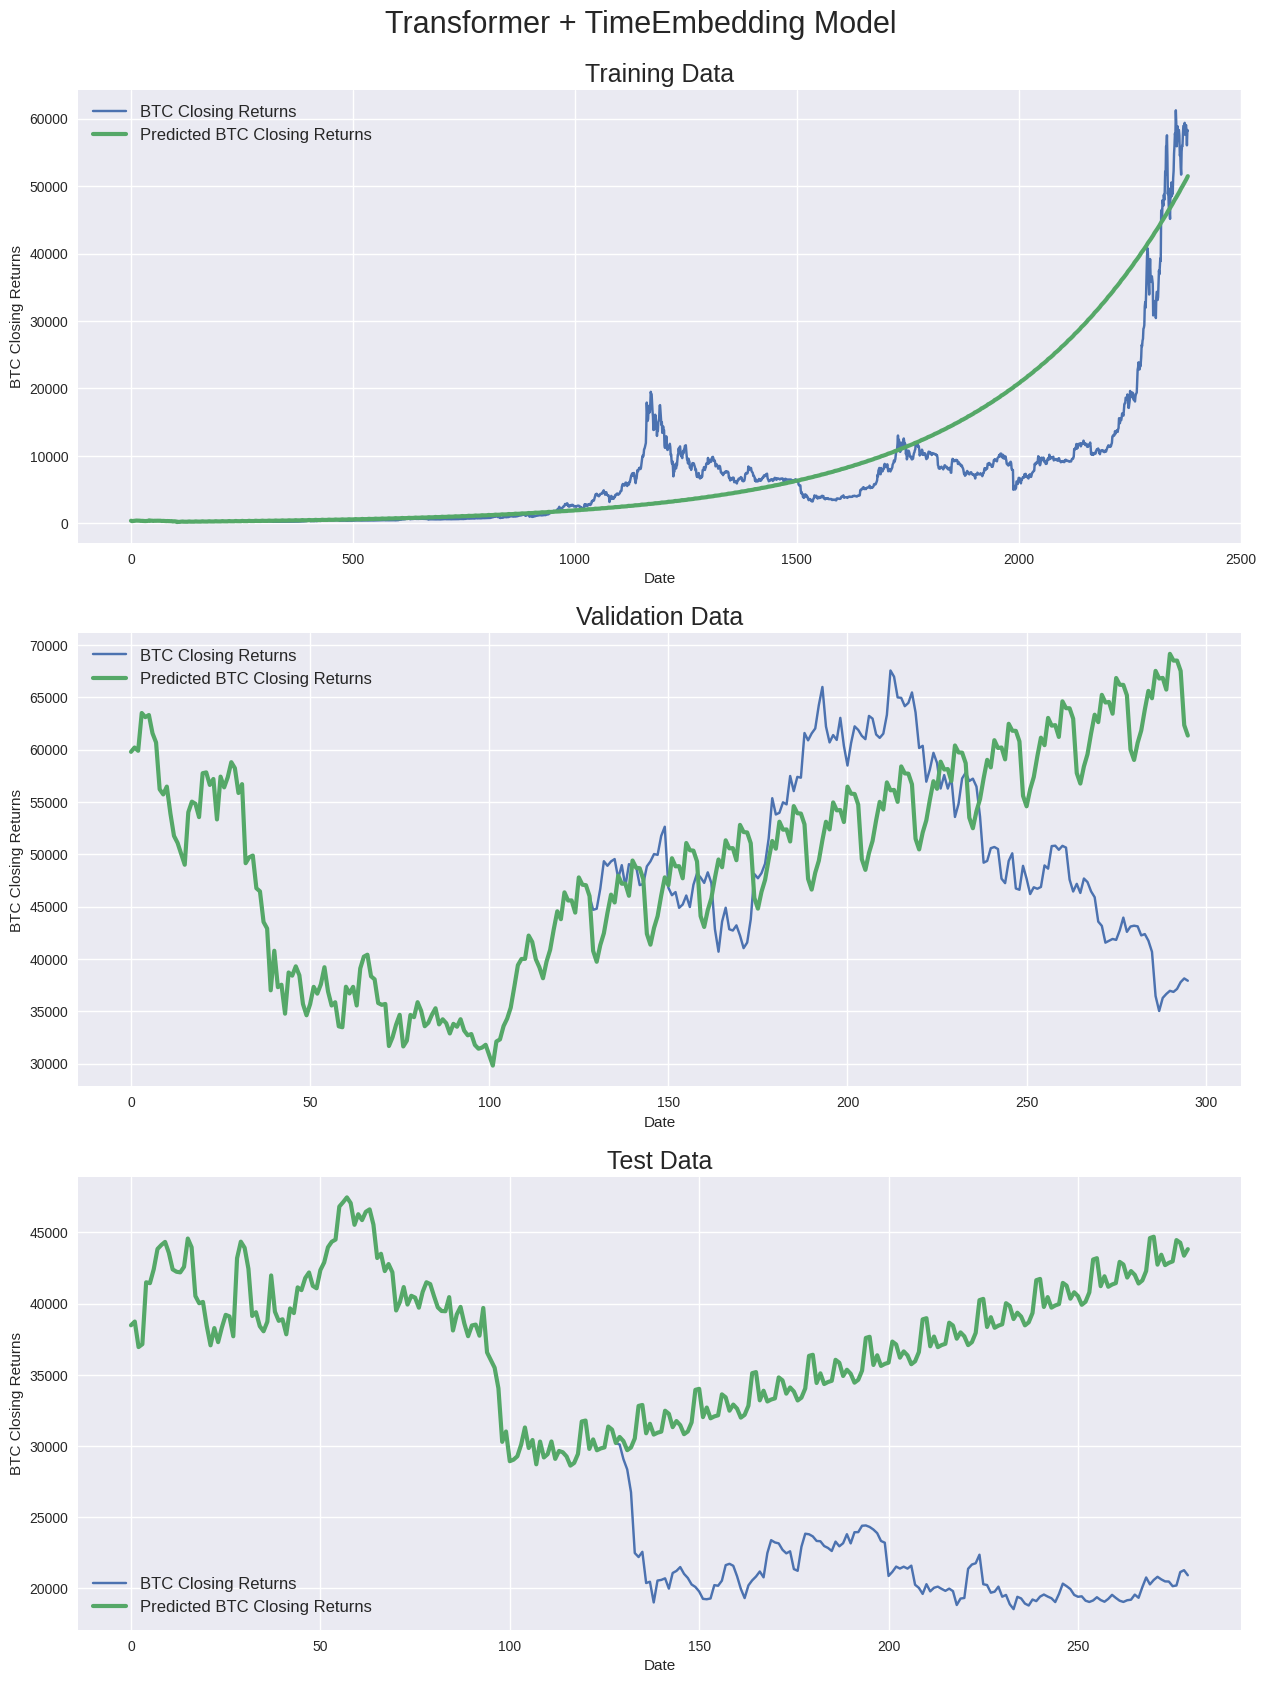

In [20]:
###############################################################################
'''Display results'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Transformer + TimeEmbedding Model", fontsize=22)
st.set_y(0.92)

#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(pred_df_train['original_close'], label='BTC Closing Returns')
ax11.plot(pred_df_train['Close'], linewidth=3, label='Predicted BTC Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('BTC Closing Returns')
ax11.legend(loc="best", fontsize=12)

#Plot validation data results
ax21 = fig.add_subplot(312)
ax21.plot(pred_df_val['original_close'], label='BTC Closing Returns')
ax21.plot(pred_df_val['Close'], linewidth=3, label='Predicted BTC Closing Returns')
ax21.set_title("Validation Data", fontsize=18)
ax21.set_xlabel('Date')
ax21.set_ylabel('BTC Closing Returns')
ax21.legend(loc="best", fontsize=12)

#Plot test data results
ax31 = fig.add_subplot(313)
ax31.plot(pred_df_test['original_close'], label='BTC Closing Returns')
ax31.plot(pred_df_test['Close'], linewidth=3, label='Predicted BTC Closing Returns')
ax31.set_title("Test Data", fontsize=18)
ax31.set_xlabel('Date')
ax31.set_ylabel('BTC Closing Returns')
ax31.legend(loc="best", fontsize=12)

In [21]:
#Plot training data results
ax11 = fig.add_subplot(311)
ax11.plot(train_data[:, 3], label='IBM Closing Returns')
ax11.plot(np.arange(seq_len, train_pred.shape[0]+seq_len), train_pred, linewidth=3, label='Predicted IBM Closing Returns')
ax11.set_title("Training Data", fontsize=18)
ax11.set_xlabel('Date')
ax11.set_ylabel('IBM Closing Returns')
ax11.legend(loc="best", fontsize=12)

In [22]:
train_val_test_pred.shape[0]

NameError: name 'train_val_test_pred' is not defined

In [ ]:
'''Display model metrics'''

fig = plt.figure(figsize=(15,20))
st = fig.suptitle("Moving Average - Transformer + TimeEmbedding Model Metrics", fontsize=22)
st.set_y(0.92)

#Plot model loss
ax1 = fig.add_subplot(311)
ax1.plot(history.history['loss'], label='Training loss (MSE)')
ax1.plot(history.history['val_loss'], label='Validation loss (MSE)')
ax1.set_title("Model loss", fontsize=18)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (MSE)')
ax1.legend(loc="best", fontsize=12)

#Plot MAE
ax2 = fig.add_subplot(312)
ax2.plot(history.history['mae'], label='Training MAE')
ax2.plot(history.history['val_mae'], label='Validation MAE')
ax2.set_title("Model metric - Mean average error (MAE)", fontsize=18)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Mean average error (MAE)')
ax2.legend(loc="best", fontsize=12)

#Plot MAPE
ax3 = fig.add_subplot(313)
ax3.plot(history.history['mape'], label='Training MAPE')
ax3.plot(history.history['val_mape'], label='Validation MAPE')
ax3.set_title("Model metric - Mean average percentage error (MAPE)", fontsize=18)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Mean average percentage error (MAPE)')
ax3.legend(loc="best", fontsize=12)